# Modeling Non-Stationary Data: The ARIMA Model

* The need for ARIMA 
  * ARMA models perform subpar when computing non-stationary data 
  * ARIMA = Autoregressive Integrated Moving Average Model
  * "Integrated" accounts for the number of non-seasonal differences we need to examine to establish stationarity 
  * Such a model targets the difference between the values in period T and the one preceding it
  * It essentially estimates the jumps between prices rather than the actual prices
  * In a sense it assumes a sort of random walk element to our data set and models the differences from one period to the next instead of the values themselves 
  * The purpose behind this complication of the model is to ensure staionarity no matter the underlying data. 
  * For some types of data including a single factor of integration is enough to reach stationarity. 
    * transforming prices into price returns is a way of brute integration 

* ARIMA notation

  * ARIMA(p, d, q); three orders to define
    * p: AR lags
    * q: MA lags 
    * d: integration order 
  * d: Integration
    * The number of times we need to integrate the time-series to ensure stationarity 
    * ARIMA(p, 0, q) = ARMA(p, q)
    * ARIMA(0, 0, q) = AR(q)
    * ARIMA(p, 0, 0) = MA(q)

* ARMA intuition 

  * "accounting for the non-seasonal difference between periods  to establish stationarity"
  * Hence, even the AR components in the model should be price differences rather than prices 
  * In a sense, we are integrating D many times to construct a new time series and then fitting said series into an ARIMA(p, q) model. 

* Equation

  * ARIMA(1, 1, 1):

    * $$
      \Delta P_t = c + \varphi_1\Delta P_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t
      $$

    * $P_t, P_{t-1}$: Values in the current period and 1 period ago 

    * $\epsilon_t, \epsilon_{t-1}$: Error terms for the same two periods 

    * $c$: Baseline constant factor 

    * $\varphi_1$: What part of the value last period is relevant in explaining the current one 

    * $\theta_1$: What part of the error last period is relevant in explaining the currnet value

    * $\Delta P_t = P_t - P_{t-1}$

  * ARIMA(p, d, q) is an ARMA(p, q) model for a newly generated time-series

* Process

  * Cannot use ACF or PACF directly using the raw data 
  * Instead, examine the ACF of the residuals 
  * Note that we will lose a single observation for any integration 



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

# Importing the data and pre-processing

In [6]:
raw_csv_data = pd.read_csv('../data/Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [7]:
df_comp['market_value'] = df_comp.ftse

In [8]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

In [10]:
df['returns'] = df.market_value.pct_change(1) * 100

# LLR Test

In [9]:
def LLR_test(mod_1, mod_2, DF=1):
    # DF: degrees of freedom
    
    # log likelihood
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    
    # test statistic
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    
    return p

# ARIMA(1, 1, 1) 

In [14]:
df.market_value.head()

date
1994-01-07    3445.98
1994-01-10    3440.58
1994-01-11    3413.77
1994-01-12    3372.02
1994-01-13    3360.01
Freq: B, Name: market_value, dtype: float64

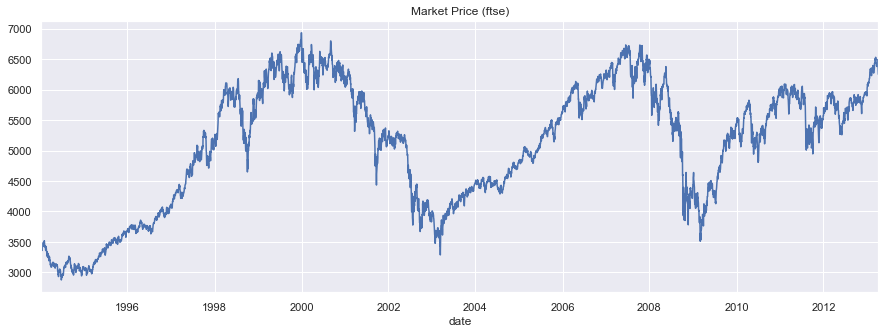

In [17]:
df.market_value.plot(figsize=(15, 5))
plt.title("Market Price (ftse)")
plt.show()

In [19]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/a

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Sun, 07 Feb 2021   AIC                          55215.333
Time:                        15:30:33   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.651      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.377      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

Note that there are only two coefficients to estimate; one for AR and the other for MA. The integration part of the ARIMA order is for transforming the underlying data, not to estimate.
$$ \text{ARIMA}(1, 1, 1) = \Delta P_t = c + \varphi_1\Delta P_{t-1} + \theta_1\epsilon_{t-1} + \epsilon_t$$

The p-value for the constant is 0.407, suggesting that it is not significantly different from 0. So far, constant was zero for returns, and non-zero for prices. This suggests that ARIMA model with prices is close to ARMA with returns. 

# Residuals of the ARIMA(1, 1, 1)

In [22]:
df['res_ar_1_i_1_ma_1']

date
1994-01-07          NaN
1994-01-10    -5.965568
1994-01-11   -27.627922
1994-01-12   -43.712019
1994-01-13   -15.569143
                ...    
2013-04-01    -0.660106
2013-04-02    78.253332
2013-04-03   -67.413168
2013-04-04   -77.203354
2013-04-05   -98.814786
Freq: B, Name: res_ar_1_i_1_ma_1, Length: 5021, dtype: float64

/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


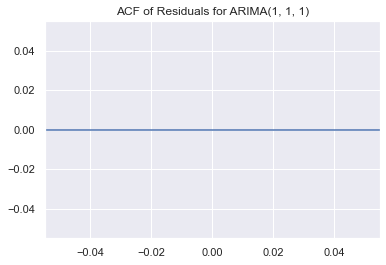

In [20]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1, 1, 1)")
plt.show()

The ACF failed to compute due to the missing value at the first element. Since the ACF starts by trying to compare elements from the very first one going foward, a missing value at the very beginning causes it to break. The easiest solution to this is to remove the first element. 

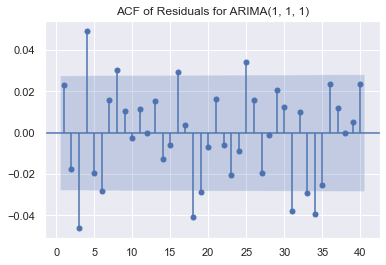

In [23]:
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1, 1, 1)")
plt.show()

The third and forth lags seems significant. Incorporating thses lags into our model might significantly improve the model performance.

# Higher-Lag ARIMA Models

We will avoid doing all the unncessary trial and error steps we did for the ARMA model.

Based on the fact that the third and fourth lags are significant, it leads us to experiment all from ARIMA(1, 1, 1) to ARIMA(4, 1, 4). Among those 15 models, these are the 5 models that yield all significant coefficients at the 5 percent level:
- ARIMA(1, 1, 2)
- ARIMA(1, 1, 3)
- ARIMA(2, 1, 1)
- ARIMA(3, 1, 2)
- ARIMA(3, 1, 2)


In [25]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)


/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/minkyung/Dropbox/mk-personal-repo/snp500-analysis/venv-snp/lib/python3.9/site-packages/statsmodels/tsa/a

As always, make sure to provide enough starting AR lags for each model to allow the execution of the fit method without crashing by simply giving a numeric value greater than the AR order. We do that only for ARIMA(3,1,2) but remember to account for them with more complicated models. 